# EFTfitter.jl - BLUE Example

When using multiple measurements of a single observable and a uniform prior for
the parameter representing the combined value, the combination of measurements performed with EFTfitter.jl
yields the same results as the Best Linear Unbiased Estimator (BLUE) method.

Here, we demonstrate this by using the examples of the paper
"How to combine correlated estimates of a single physical quantity"
by L. Lyons, D. Gibaut and P. Clifford (https://www.sciencedirect.com/science/article/pii/0168900288900186).
All numbers are taken from the example on charm particle lifetime experiments in section 5.
A factor of 10^13 is applied for convenience.

In [1]:
using EFTfitter
using BAT
using IntervalSets
using Statistics
using StatsBase
using LinearAlgebra
using Plots

We need one parameter for the best estimator and choose
a uniform distribution in the range 8 to 14 as prior:

In [2]:
parameters = BAT.NamedTupleDist(
    τ = 8..14,
)

ValueShapes.NamedTupleDist{(:τ,),Tuple{Distributions.Uniform{Float64}},Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}(
_internal_distributions: (τ = Distributions.Uniform{Float64}(a=8.0, b=14.0),)
_internal_shape: ValueShapes.NamedTupleShape{(:τ,),Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}((τ = ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}(ValueShapes.ScalarShape{Real}(), 0, 1),), 1)
)


When combining multiple measurements of the same observable,
only a function returning the combination parameter is needed:

In [3]:
estimator(params) = params.τ

estimator (generic function with 1 method)

In Eq. (17') of the reference paper the following covariance matrix is given:

In [4]:
covariance = [2.74 1.15 0.86 1.31;
              1.15 1.67 0.82 1.32;
              0.86 0.82 2.12 1.05;
              1.31 1.32 1.05 2.93]

4×4 Array{Float64,2}:
 2.74  1.15  0.86  1.31
 1.15  1.67  0.82  1.32
 0.86  0.82  2.12  1.05
 1.31  1.32  1.05  2.93

For using this in EFTfitter.jl, we first need to convert the covariance matrix
into a correlation matrix and the corresponding uncertainty values:

In [5]:
corr, unc = EFTfitter.cov_to_cor(covariance)

measurements = (
    τ1 = Measurement(estimator,  9.5, uncertainties = (stat=unc[1],) ),
    τ2 = Measurement(estimator, 11.9, uncertainties = (stat=unc[2],) ),
    τ3 = Measurement(estimator, 11.1, uncertainties = (stat=unc[3],) ),
    τ4 = Measurement(estimator,  8.9, uncertainties = (stat=unc[4],) ),
)

correlations = (
    stat = Correlation(corr),
)

(stat = EFTfitter.Correlation([1.0 0.5376062677719541 0.35682497116489126 0.46234078289360164; 0.5376062677719541 1.0 0.4358004620316949 0.5967355144471027; 0.35682497116489126 0.4358004620316949 1.0 0.4212962160310593; 0.46234078289360164 0.5967355144471027 0.4212962160310593 1.0], true),)

construct an `EFTfitterModel`:

In [6]:
model = EFTfitterModel(parameters, measurements, correlations)
posterior = PosteriorMeasure(model);

sample the posterior with BAT.jl:

In [7]:
algorithm = MCMCSampling(mcalg =MetropolisHastings(), nsteps = 10^6, nchains = 4)
samples = bat_sample(posterior, algorithm).result

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm BAT.PriorSubstitution()
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/cornelius/Projects/julia/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC T

1291354-element StructArray(::ValueShapes.ShapedAsNTArray{NamedTuple{(:τ,),Tuple{Float64}},1,ArraysOfArrays.ArrayOfSimilarArrays{Float64,1,1,2,ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}}},ValueShapes.NamedTupleShape{(:τ,),Tuple{ValueShapes.ValueAccessor{ValueShapes.ScalarShape{Real}}}}}, ::Array{Float64,1}, ::Array{Int64,1}, StructArray(::Array{Int32,1}, ::Array{Int32,1}, ::Array{Int64,1}, ::Array{Int64,1}), ::Array{Nothing,1}) with eltype BAT.DensitySample{NamedTuple{(:τ,),Tuple{Float64}},Float64,Int64,BAT.MCMCSampleID,Nothing}:
 BAT.DensitySample{NamedTuple{(:τ,),Tuple{Float64}},Float64,Int64,BAT.MCMCSampleID,Nothing}((τ = 11.580451743448599,), -7.94182231363417, 5, BAT.MCMCSampleID(8, 4, 0, 1), nothing)
 BAT.DensitySample{NamedTuple{(:τ,),Tuple{Float64}},Float64,Int64,BAT.MCMCSampleID,Nothing}((τ = 11.317447751934166,), -7.8235686644533695, 1, BAT.MCMCSampleID(8, 4, 5, 1), nothing)
 BAT.DensitySample{NamedTuple{(:τ,),Tuple{Float64}},Float64,Int64,BAT.MCMCSampleID,Nothin

plot the posterior distribution for the combination parameter τ:

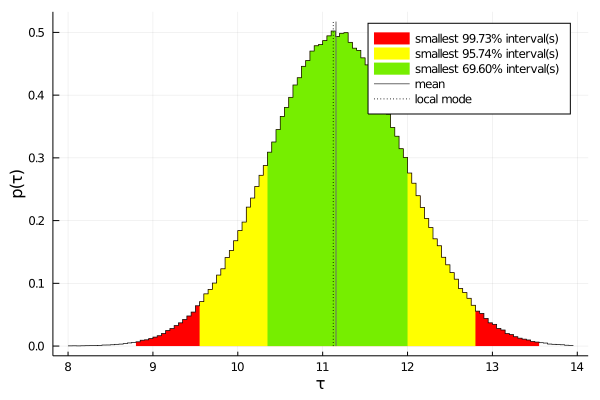

In [8]:
plot(samples, :τ, mean=true)

print numerical results of combination:

In [9]:
println("Mode: $(mode(samples).τ)")
println("Mean: $(mean(samples).τ) ± $(std(samples).τ)")

Mode: fill(11.159830807423306)
Mean: fill(11.157048014558068) ± fill(0.800971609231456)


### Comparison with BLUE method

In [10]:
blue = BLUE(model)
println("BLUE: $(blue.value) ± $(blue.unc)")
println("BLUE weights: $(blue.weights)")

BLUE: 11.159830517412002 ± 1.2860408471758553
BLUE weights: [0.14507475718273513, 0.4695773808477563, 0.3472970547995881, 0.03805080716992032]


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*